In [2]:
!pip install shapely
!pip install tripy
!pip install imutils
import tripy
import cv2
import math
import os
import sys
import time
import numpy as np
import skimage.io
from skimage.transform import rescale, resize, downscale_local_mean
from skimage.measure import label, regionprops
from matplotlib import pyplot as plt
from shapely.geometry import Polygon
from shapely.ops import split
import json
import imutils


ROOT_DIR = os.getcwd()

You are using pip version 18.1, however version 20.3.4 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 18.1, however version 20.3.4 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 18.1, however version 20.3.4 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [11]:
image = skimage.io.imread(os.path.join(ROOT_DIR, "data/block_1.png"))

max_y = image.shape[0]
    
points = [(224, max_y - 580), (729, max_y - 97), (898, max_y - 216), (390, max_y - 697), (224, max_y - 580)]

cv2.line(image,points[0],points[1],(0,255,0),5)
cv2.line(image,points[1],points[2],(0,255,0),5)
cv2.line(image,points[2],points[3],(0,255,0),5)
cv2.line(image,points[3],points[4],(0,255,0),5)
cv2.line(image,points[4],points[0],(0,255,0),5)
for p in points:
    cv2.circle(image, p, 1, (2, 255, 255), thickness=10)
    
plt.figure()
plt.gca().invert_yaxis()
plt.imshow(image)

FileNotFoundError: [Errno 2] No such file or directory: '/data/data/block_1.png'

In [94]:
poly = Polygon(points)
image = skimage.io.imread(os.path.join(ROOT_DIR, "block_1.png"))

print(list(poly.exterior.coords))
print(poly.area / poly.minimum_rotated_rectangle.area)
print(poly.minimum_rotated_rectangle.area)
print(poly.area)

min_rect_points = [(364, 67), (898, 577), (757, 724), (224, 214), (364, 67)]
cv2.line(image,min_rect_points[0],min_rect_points[1],(255,255,0),5)
cv2.line(image,min_rect_points[1],min_rect_points[2],(255,255,0),5)
cv2.line(image,min_rect_points[2],min_rect_points[3],(255,255,0),5)
cv2.line(image,min_rect_points[3],min_rect_points[4],(255,255,0),5)
cv2.line(image,min_rect_points[4],min_rect_points[0],(255,255,0),5)

plt.figure()
plt.gca().invert_yaxis()
plt.imshow(image)

if(poly.area / poly.minimum_rotated_rectangle.area) > 0.9:
    print("isRectangle")

FileNotFoundError: [Errno 2] No such file or directory: '/data/block_1.png'

In [3]:
def draw_polygon(image, points):
    for index in range(len(points) - 1):
        cv2.line(image,tuple(points[index]),tuple(points[index+1]),(255,255,0),5)
        
    cv2.line(image,tuple(points[len(points) - 1]),tuple(points[0]),(255,255,0),5)

def distance(p1, p2):
        return int(math.sqrt((p1[0]-p2[0])**2 + (p1[1]-p2[1])**2))
    
def rotate_box(bb, cx, cy, h, w, theta):
    new_bb = list(bb)
    for i,coord in enumerate(bb):
        # opencv calculates standard transformation matrix
        M = cv2.getRotationMatrix2D((cx, cy), theta, 1.0)
        # Grab  the rotation components of the matrix)
        cos = np.abs(M[0, 0])
        sin = np.abs(M[0, 1])
        # compute the new bounding dimensions of the image
        nW = int((h * sin) + (w * cos))
        nH = int((h * cos) + (w * sin))
        # adjust the rotation matrix to take into account translation
        M[0, 2] += (nW / 2) - cx
        M[1, 2] += (nH / 2) - cy
        # Prepare the vector to be transformed
        v = [coord[0],coord[1],1]
        # Perform the actual rotation and return the image
        calculated = np.dot(M,v)
        new_bb[i] = (calculated[0],calculated[1])
    return new_bb

def rotate_point(image, coord, angle):
    # grab the dimensions of the image and then determine the
    # center
    (h, w) = image.shape[:2]
    (cX, cY) = (w // 2, h // 2)
    # grab the rotation matrix (applying the negative of the
    # angle to rotate clockwise), then grab the sine and cosine
    # (i.e., the rotation components of the matrix)
    M = cv2.getRotationMatrix2D((cX, cY), -angle, 1.0)
    cos = np.abs(M[0, 0])
    sin = np.abs(M[0, 1])
    # compute the new bounding dimensions of the image
    nW = int((h * sin) + (w * cos))
    nH = int((h * cos) + (w * sin))
    # adjust the rotation matrix to take into account translation
    M[0, 2] += (nW / 2) - cX
    M[1, 2] += (nH / 2) - cY
    
    v = [coord[0],coord[1],1]
    # Perform the actual rotation and return the image
    calculated = np.dot(M,v)
    new_bb = (calculated[0],calculated[1])
    
    return new_bb


def findRotationAngle(image, a, b):

    def distance(p1, p2):
        return int(math.sqrt((p1[0]-p2[0])**2 + (p1[1]-p2[1])**2))
    
    line_length = distance(a, b)
    shape = image.shape
    
    r_a = a
    r_b = (a[0] + line_length, a[1])
    
    l1 = [a, b]
    l2 = [r_a, r_b]
    
    m1 = (b[1] - a[1])/(b[0] - a[0])
    m2 = (r_b[1] - r_a[1])/(r_b[0] - r_a[0])

    angle1 = math.atan(m1)
    angle2 = math.atan(m2)
    
    angle_deg = (angle2-angle1)*180/math.pi
    
    return angle_deg


def getRotatedImageAndDividingLine(img_org, a, b):
    theta = findRotationAngle(img_org, a, b)

    rotated_img = imutils.rotate_bound(img_org, -1*theta)

    heigth, width = img_org.shape[:2]
    (cx, cy) = (width // 2, heigth // 2)

    bb1 = {}
    bb1[0] = [a, b]

    new_bb = {}
    for i in bb1:
        new_bb[i] = rotate_box(bb1[i], cx, cy, heigth, width, -1*theta)

    r_a = (int(new_bb[0][0][0]), int(new_bb[0][0][1]))
    r_b = (int(new_bb[0][1][0]), int(new_bb[0][1][1]))
    
    return rotated_img, r_a, r_b, theta

def roundToNearestPowerOf2(val):
    result = 0
    
    prev_diff = val - result
    
    while(1):
        result += 256
        diff = val - result
        if(diff < 0):
            diff = -1*diff
        
        if diff < prev_diff:
            prev_diff = diff
        else:
            result -= 256
            break
        
    
    return result



In [4]:
# Opening JSON file
f = open('data/dha-phase2/data.json')
 
# returns JSON object as
# a dictionary
data = json.load(f)


keys = []
for k in data: 
    keys.append(k)
    
for key in keys:
    points = data[key]
    points_arr = np.asarray(points, dtype=np.int32)
    
    #plot shape
    points_Arr = data[key]
    xs, ys = zip(*points_Arr)
    plt.figure()
    plt.plot(xs,ys)
    
    
    
    
    
    img_path = "data/dha-phase2/{}".format(key)
    image = cv2.imread(os.path.join(ROOT_DIR, img_path))
    
    isClosed = True
    
    
    poly = Polygon(points)
    mbr_points = list(zip(*poly.minimum_rotated_rectangle.exterior.coords.xy))
    
    side1 = distance(mbr_points[0],mbr_points[1])
    side2 = distance(mbr_points[1],mbr_points[2])
    
    if side1 > side2:
        point1 = mbr_points[0]
        point2 = mbr_points[1]
    else:
        point1 = mbr_points[1]
        point2 = mbr_points[2]
        
    major_axis_points = [point1,point2]

    major_axis_points = [list(x) for x in major_axis_points]
    
    
    
    ## (1) Crop the bounding rect
#     rect = cv2.boundingRect(points_arr)
#     x,y,w,h = rect
#     thresh = 0
#     cropped = image[y-thresh:y+h+thresh, x-thresh:x+w+thresh].copy()
    plt.figure()
    xs, ys = zip(*points_Arr)
    plt.plot(xs,ys)
    xs, ys = zip(*major_axis_points)
    plt.plot(xs,ys)
    plt.imshow(np.flipud(image), cmap='gray', origin='lower')
    
    
    
    
    
    plt.figure()
    r_image, a, b, rotation_angle = getRotatedImageAndDividingLine(image, point1, point2)
    
    rotated_points = [rotate_point(image, x, rotation_angle) for x in points]
    print(rotated_points)
    
    plot_rotated_points = [list(x) for x in rotated_points]
    xs, ys = zip(*plot_rotated_points)
    plt.plot(xs,ys)
    
    rotated_points = np.asarray(rotated_points, dtype=np.int32)
    rect = cv2.boundingRect(rotated_points)
    x,y,w,h = rect
    
    print(x)
    print(y)
    print(w)
    print(h)
    thresh = 50
    cropped = r_image[y-thresh:y+h+thresh, x-thresh:x+w+thresh].copy()
    
    h, w, _ = cropped.shape
    
    plt.imshow(np.flipud(cropped), cmap='gray', origin='lower')
    
    M = 256
    N = 256
    
#     print("looph")
    
#     for y in range(0, h, 256):
#         print(y)
    
#     print("loopw")
    
#     for x in range(0, w, 256):
#         print(x)
        
#     print("loopRh")
#     for y in range(h, 0, -256):
#         print(y)
        
#     print("loopRw")
#     for x in range(w, 0, -256):
#         print(x)
        
    print("top-left loop")
    for y in range(0, h, 256):
        for x in range(0, w, 256):
            patch = cropped[y:y+M,x:x+N]
            
            if patch.shape[0] == 256 and patch.shape[1] == 256:

                plt.figure()
                plt.imshow(np.flipud(patch), cmap='gray', origin='lower')
                print(patch.shape)
            
    
    print("bottom-right loop")
    for y in range(h, 0, -256):
        for x in range(w, 0, -256):
            patch = cropped[y-M:y,x-N:x]
            
            if patch.shape[0] == 256 and patch.shape[1] == 256:
                plt.figure()
                plt.imshow(np.flipud(patch), cmap='gray', origin='lower')
                print(patch.shape)


    print("top-right loop")
    for y in range(0, h, 256):
        for x in range(w, 0, -256):
            patch = cropped[y:y+M,x-N:x]
            
            if patch.shape[0] == 256 and patch.shape[1] == 256:
                plt.figure()
                plt.imshow(np.flipud(patch), cmap='gray', origin='lower')
                print(patch.shape)


    print("bottom-left loop")
    for y in range(h, 0, -256):
        for x in range(0, w, 256):
            patch = cropped[y-M:y,x:x+N]
            
            if patch.shape[0] == 256 and patch.shape[1] == 256:
                plt.figure()
                plt.imshow(np.flipud(patch), cmap='gray', origin='lower')
                print(patch.shape)
    
    break


f.close()

FileNotFoundError: [Errno 2] No such file or directory: 'data/dha-phase2-region/data.json'

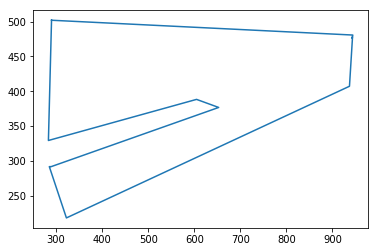

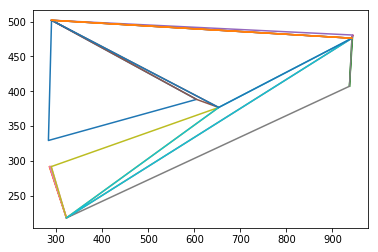

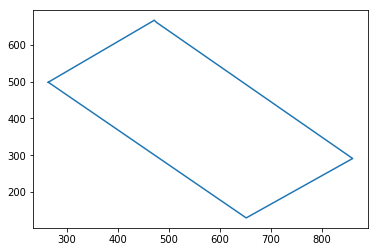

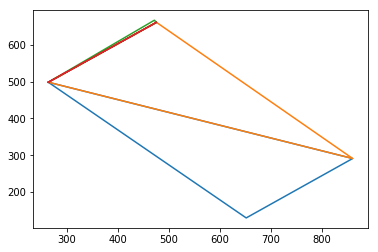

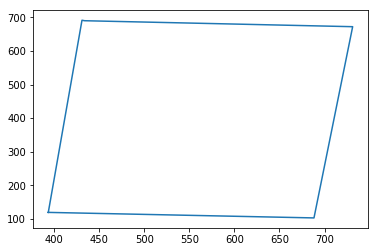

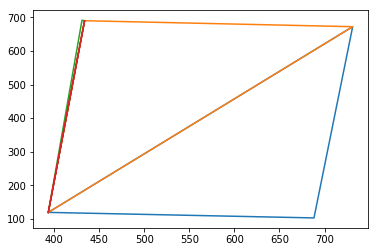

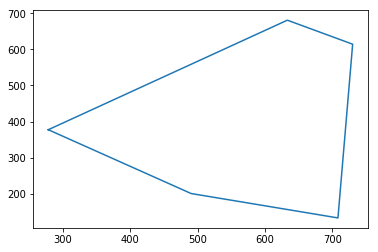

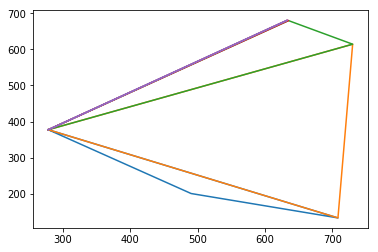

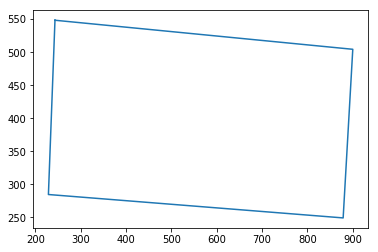

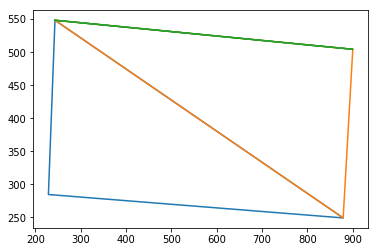

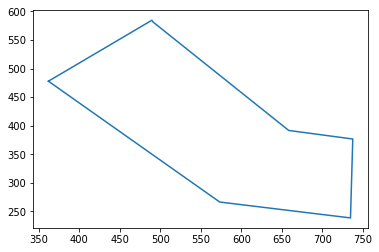

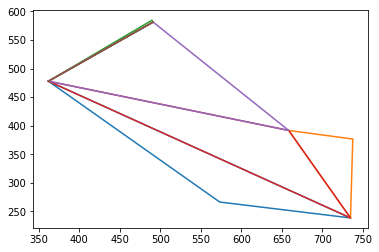

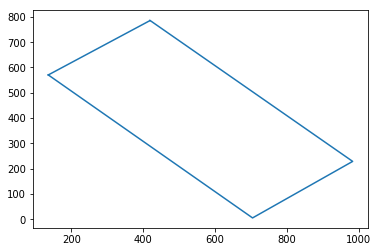

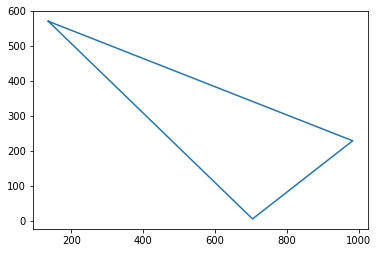

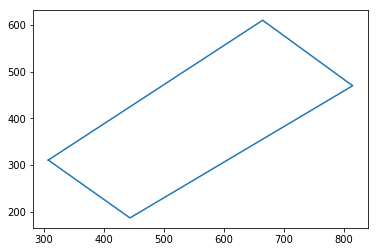

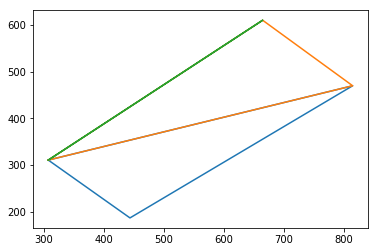

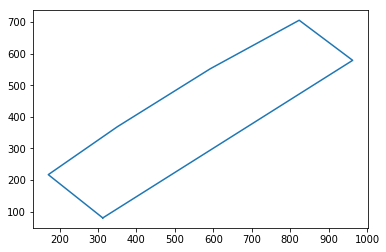

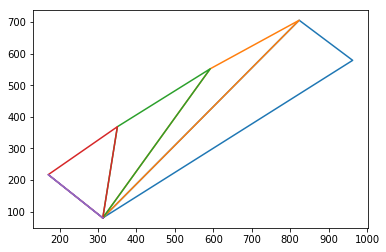

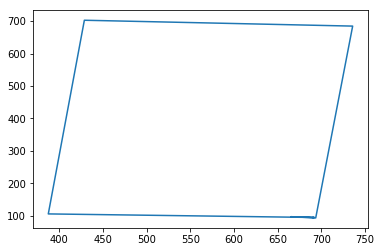

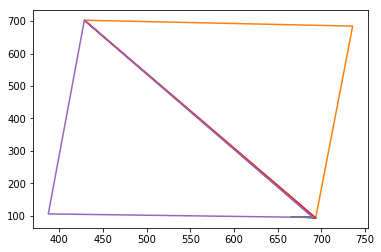

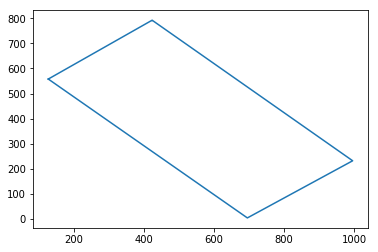

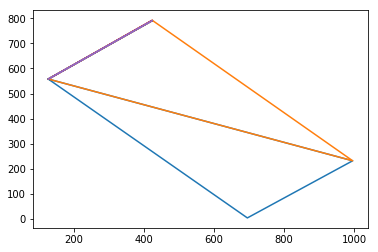

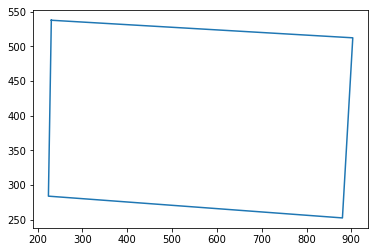

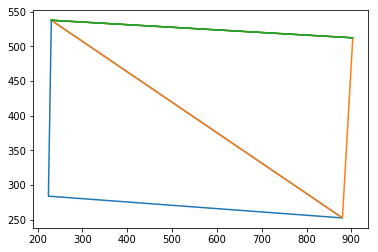

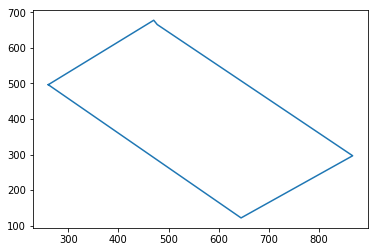

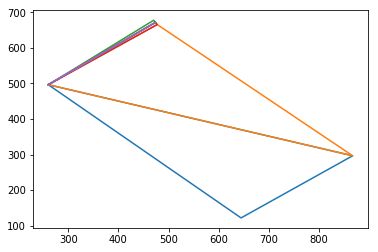

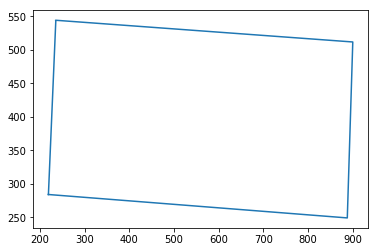

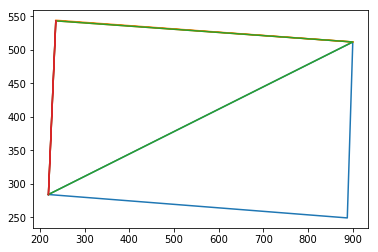

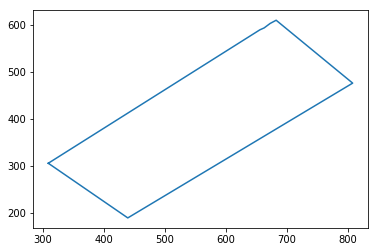

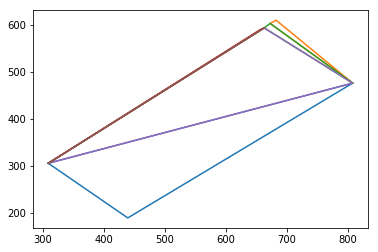

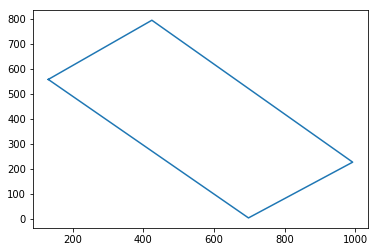

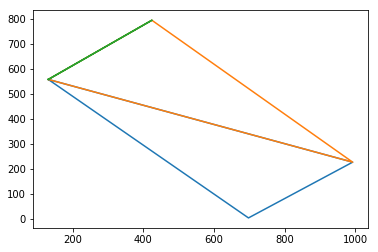

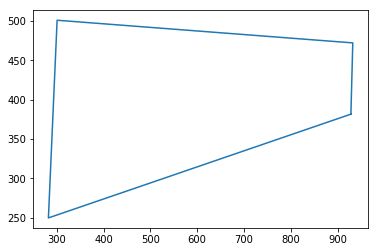

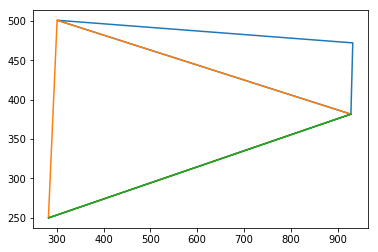

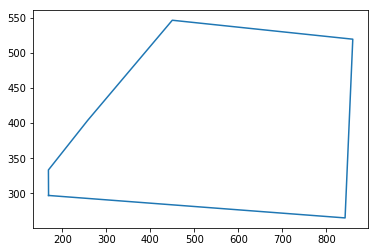

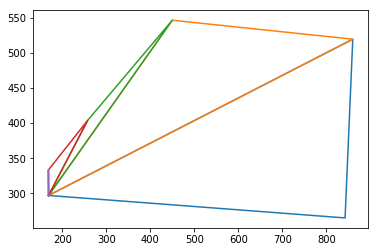

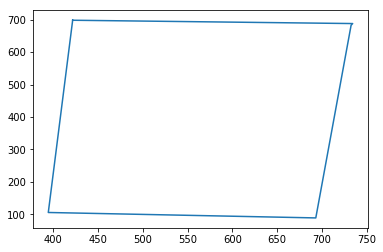

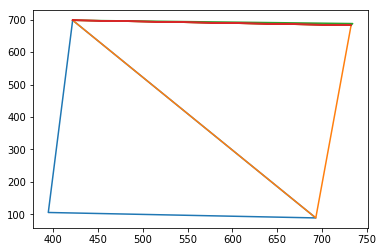

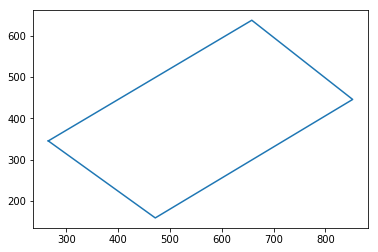

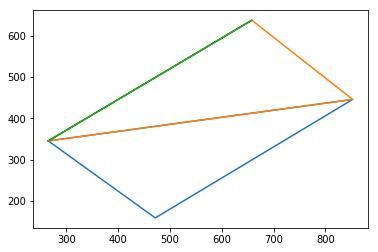

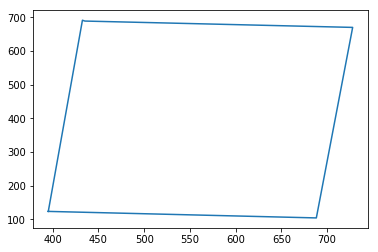

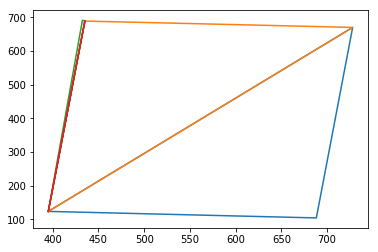

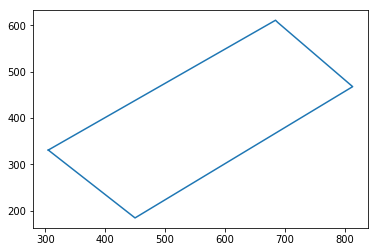

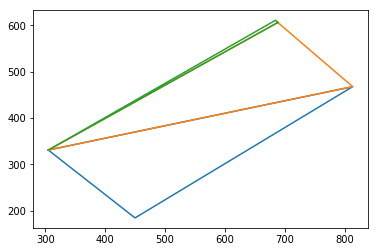

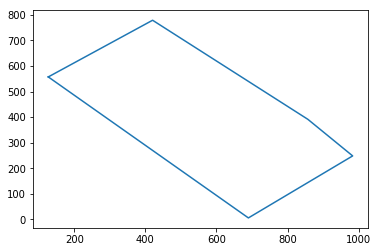

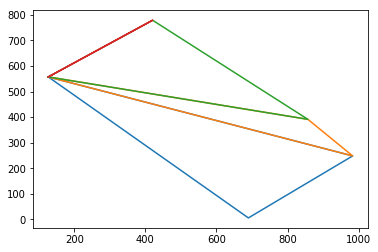

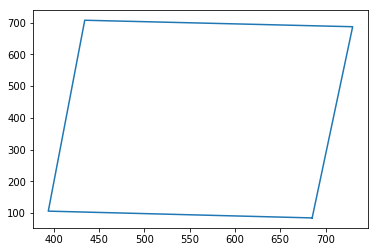

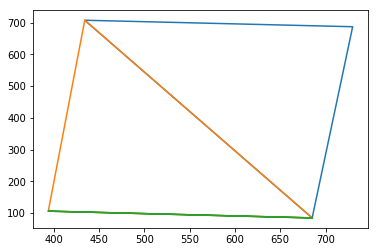

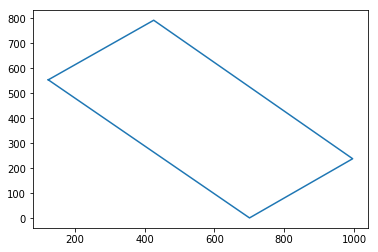

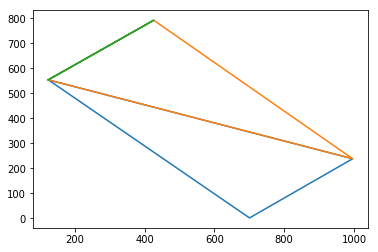

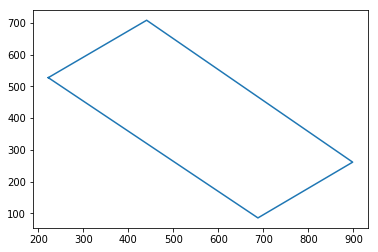

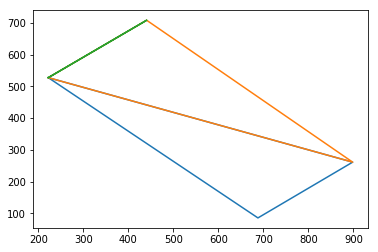

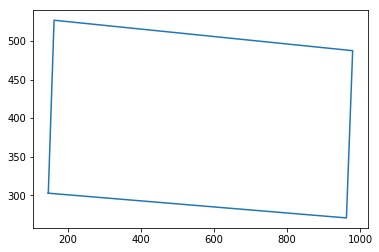

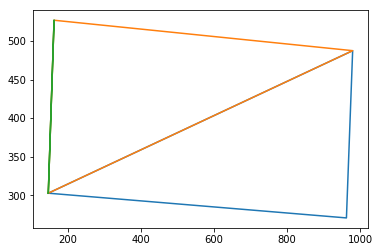

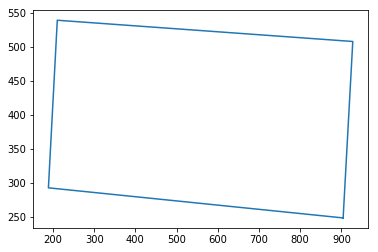

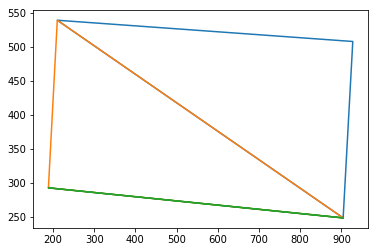

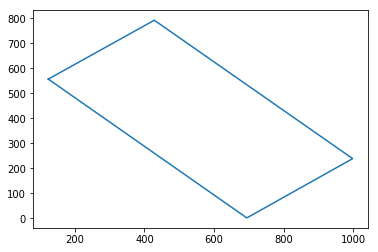

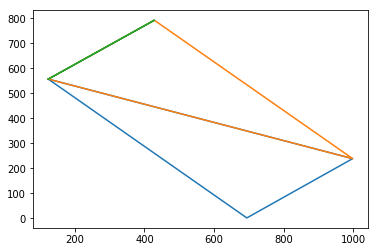

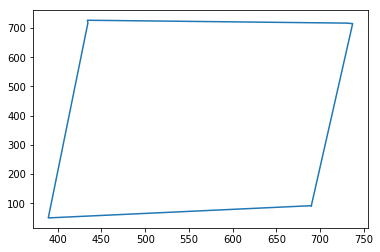

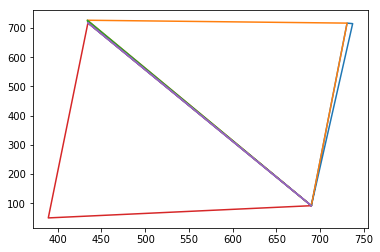

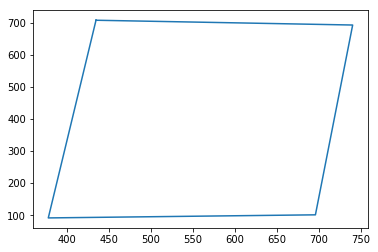

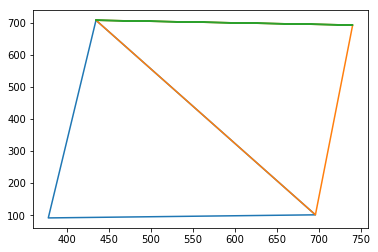

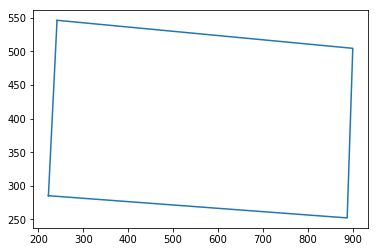

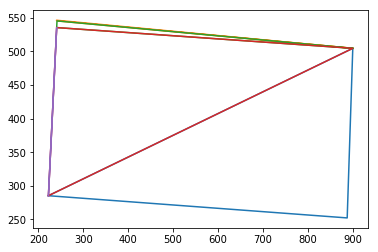

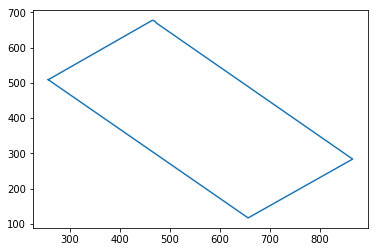

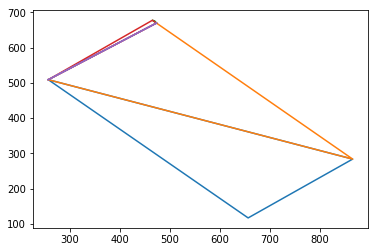

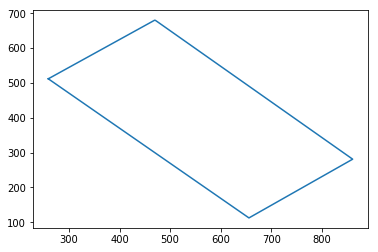

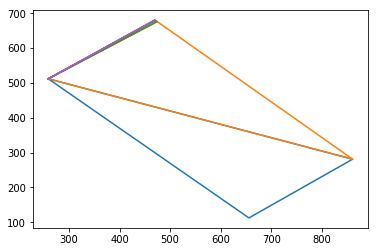

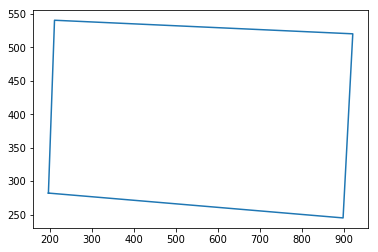

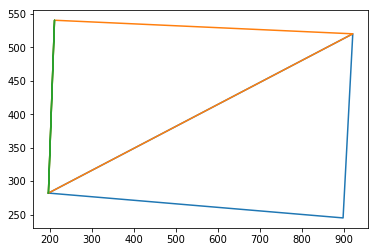

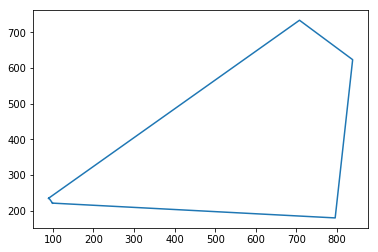

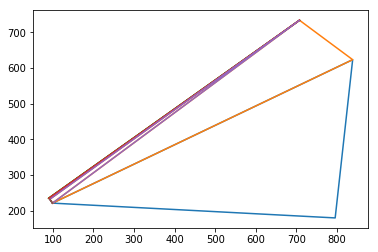

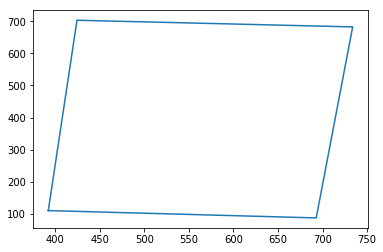

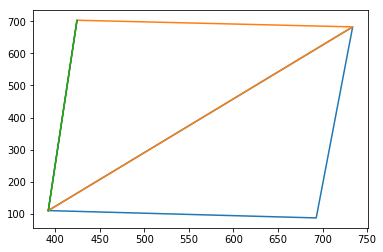

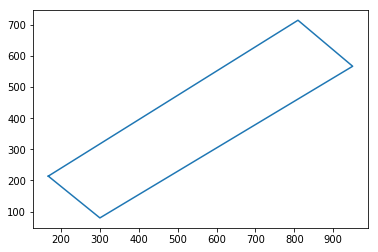

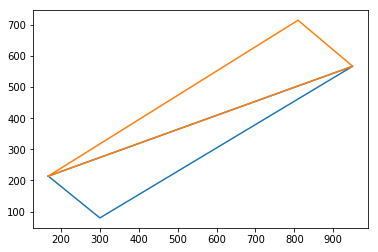

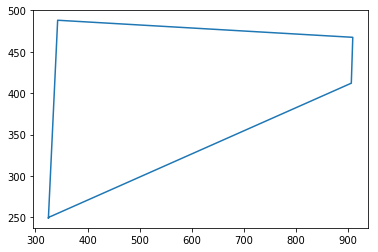

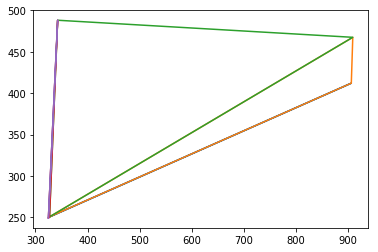

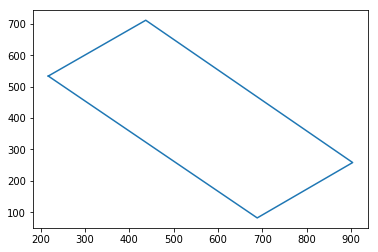

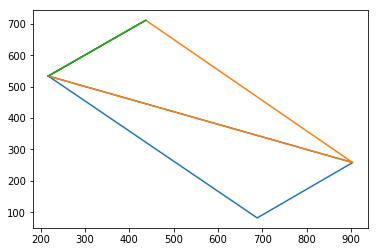

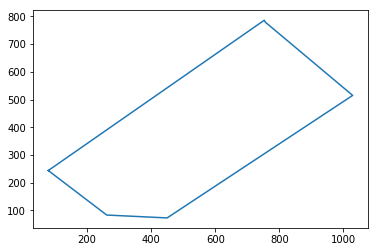

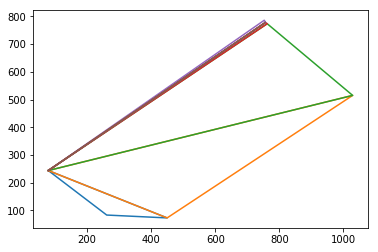

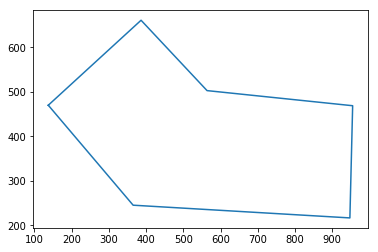

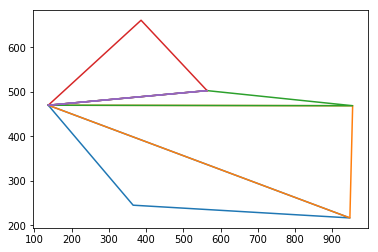

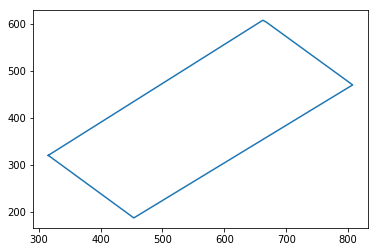

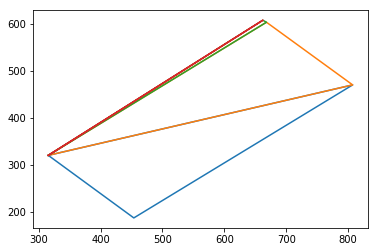

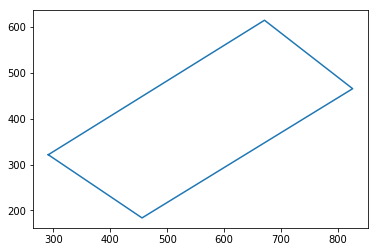

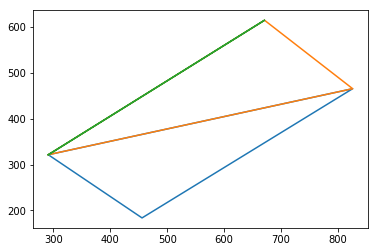

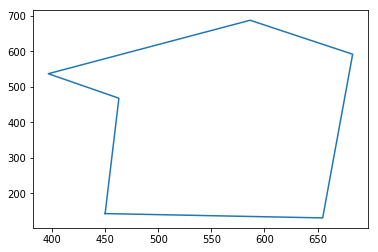

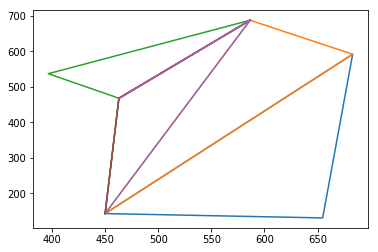

In [8]:
# Opening JSON file
f = open('data/dha-phase2/data.json')
 
# returns JSON object as
# a dictionary
data = json.load(f)

keys = []
for k in data: 
    keys.append(k)
    
for key in keys:
    plt.figure()
    points_Arr = data[key]['points']
    
    xs, ys = zip(*points_Arr)
    plt.plot(xs,ys) 
    
    plt.show()
    
    tuple_Arr = map(tuple, points_Arr)
    triangles = tripy.earclip(tuple_Arr)
    
    poly = Polygon(points_Arr)
    mbr_points = list(zip(*poly.minimum_rotated_rectangle.exterior.coords.xy))
    
    
    major_axis_points = [mbr_points[0],mbr_points[1]]
    
#     major_axis_points = [list(x) for x in major_axis_points]
#     xs, ys = zip(*major_axis_points)
#     plt.plot(xs,ys)

    plt.figure()
    
    for tri in triangles:
        triangle = [list(x) for x in tri]
        triangle.append(triangle[0])
        xs, ys = zip(*triangle)
        plt.plot(xs,ys)

    plt.show() # if you need...

f.close()

In [ ]:
ll, ur = get_maximal_rectangle(coordinates) 